In [1]:
%pip install matplotlib numpy scikit-learn

from iav_flap_anomaly_detection import make_data, plot_data

import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Installation instructions

To create the data set and show the example plots, you need to install

* matplotlib
* numpy
* sklearn

and you're good to go!

# The problem

Below is your data. We have a system that produces data that normally looks like the left picture. However, there is a special kind of problem that occurs that makes the data shift and flip. Usually, nobody has the time to look at the data and label it - we only have data of which we know that it is probably ok and serves as your training data. Can you tell the problematic data apart anyway?

In [2]:
X_train, X_test, test_ground_truth = make_data()

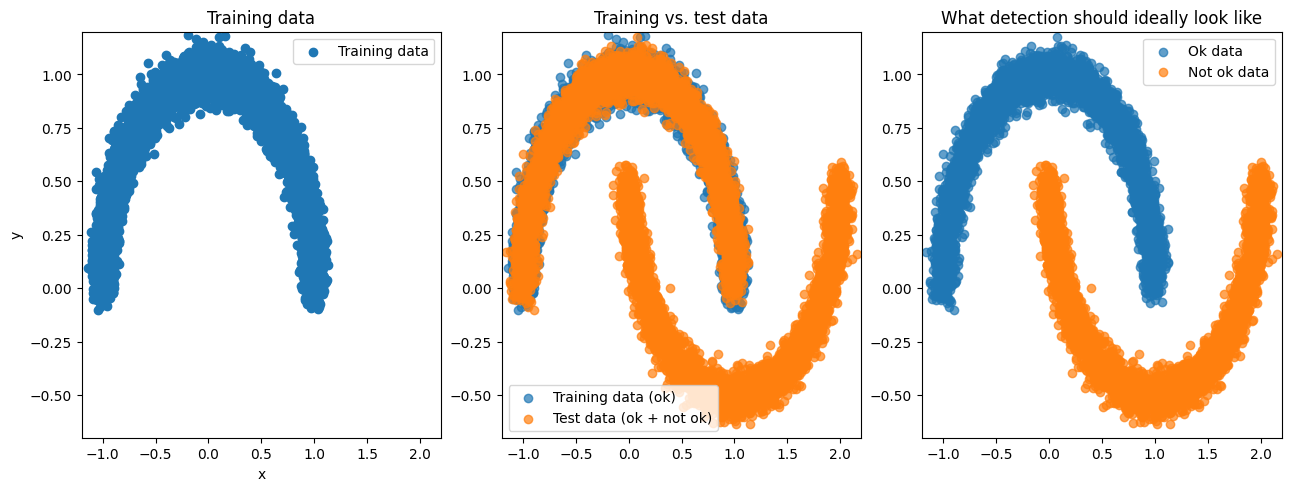

In [3]:
plot_data(X_train, X_test, test_ground_truth)

## Your task

1. Which kind of anomaly detection are you performing?

    1) Supervised
    2) Semi-supervised
    3) Unsupervised

2. Pick a suitable model, for example from scikit-learn (if you know other anomaly detection packages, we're fine with that too)
3. Train it on the training data, and ONLY the training data. Don't cheat by incorporating knowledge about the test set ;-)
4. Try to tell which points of the data are not ok (i.e. don't look like the training data)
5. How good is your model?

## Your solution

Do not hesitate to play around with several different models. Don't worry too much about accuracy - if you're at about 80%, that's fine. We told you the problem is hard ;-) ...

# 1. Type of Anomaly Detection
This is a **semi-supervised** anomaly detection problem because:

- We have labeled normal data (training set) that contains only normal points
- We need to identify anomalies in the test set without having labeled anomalies during training
- The task involves learning from normal data patterns to detect deviations (anomalies)

# 2. Solution using scikit-learn

In [4]:
# Try multiple models and compare their performance

# Model 1: Isolation Forest
clf_iso = IsolationForest(contamination='auto', random_state=42)
clf_iso.fit(X_train)
y_pred_iso = clf_iso.predict(X_test)
# Convert predictions: +1 (inliers) to 1 (normal), -1 (outliers) to -1 (anomaly)
y_pred_iso_binary = np.where(y_pred_iso == 1, 1, -1)

# Model 2: One-Class SVM
clf_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma='auto')
clf_svm.fit(X_train)
y_pred_svm = clf_svm.predict(X_test)
y_pred_svm_binary = np.where(y_pred_svm == 1, 1, -1)

# Model 3: Local Outlier Factor
clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)
clf_lof.fit(X_train)
y_pred_lof = clf_lof.predict(X_test)
y_pred_lof_binary = np.where(y_pred_lof == 1, 1, -1)

# Model 4: DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
dbscan = DBSCAN(eps=0.3, min_samples=10)
y_pred_dbscan = dbscan.fit_predict(X_test)
# Convert DBSCAN predictions: 0 (core points) and positive integers (cluster labels) to 1 (normal), and -1 (noise) to -1 (anomaly)
y_pred_dbscan_binary = np.where(y_pred_dbscan == -1, -1, 1)

In [5]:
# Evaluating model performance

def evaluate_model(y_true, y_pred, model_name):
    # Convert from +1/-1 format to 0/1 for sklearn metrics
    y_true_binary = np.where(y_true == 1, 1, 0)
    y_pred_binary = np.where(y_pred == 1, 1, 0)
    
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true_binary, y_pred_binary))
    print("\n")
    
    return accuracy, precision, recall, f1

# Evaluate all models
evaluate_model(test_ground_truth, y_pred_iso_binary, "Isolation Forest")
evaluate_model(test_ground_truth, y_pred_svm_binary, "One-Class SVM")
evaluate_model(test_ground_truth, y_pred_lof_binary, "Local Outlier Factor")
evaluate_model(test_ground_truth, y_pred_dbscan_binary, "Elliptic Envelope")

Model: Isolation Forest
Accuracy: 0.7672
Precision: 1.0000
Recall: 0.5344
F1 Score: 0.6966
Confusion Matrix:
[[5000    0]
 [2328 2672]]


Model: One-Class SVM
Accuracy: 0.8139
Precision: 0.7707
Recall: 0.8938
F1 Score: 0.8277
Confusion Matrix:
[[3670 1330]
 [ 531 4469]]


Model: Local Outlier Factor
Accuracy: 0.9462
Precision: 1.0000
Recall: 0.8924
F1 Score: 0.9431
Confusion Matrix:
[[5000    0]
 [ 538 4462]]


Model: Elliptic Envelope
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1 Score: 0.6667
Confusion Matrix:
[[   0 5000]
 [   0 5000]]




(0.5, 0.5, 1.0, 0.6666666666666666)

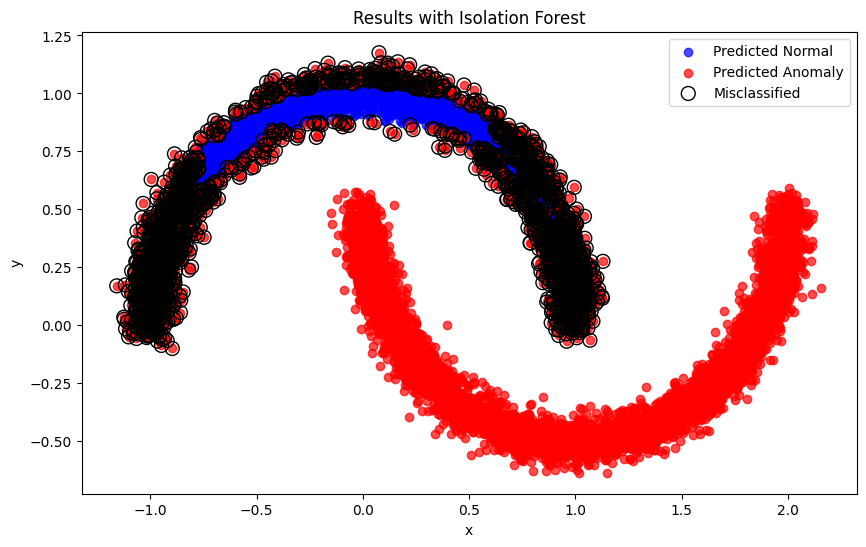

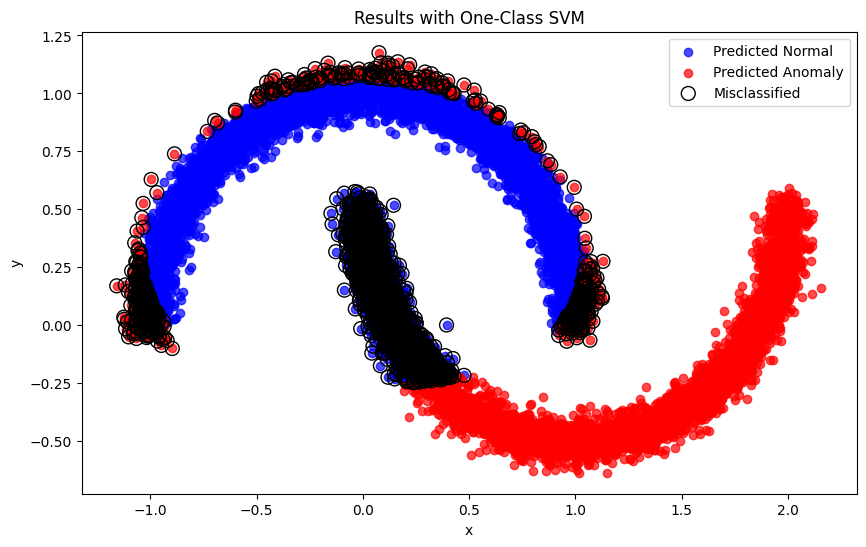

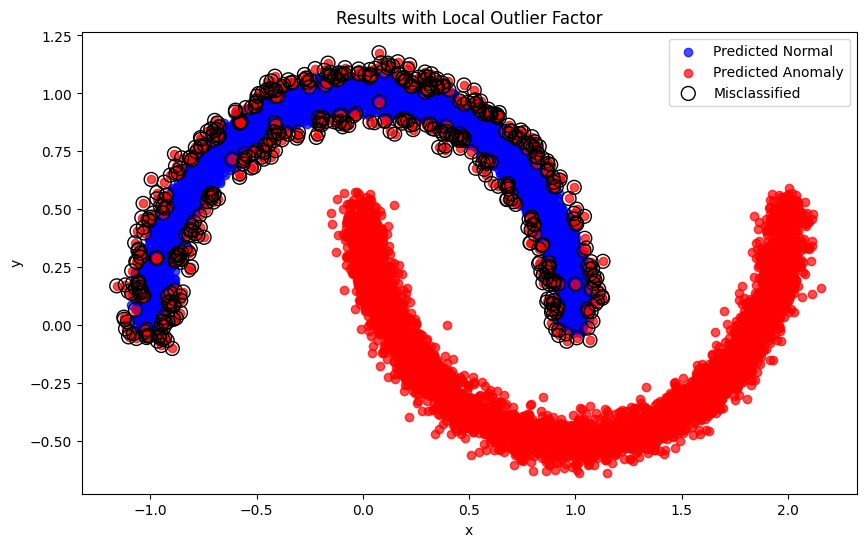

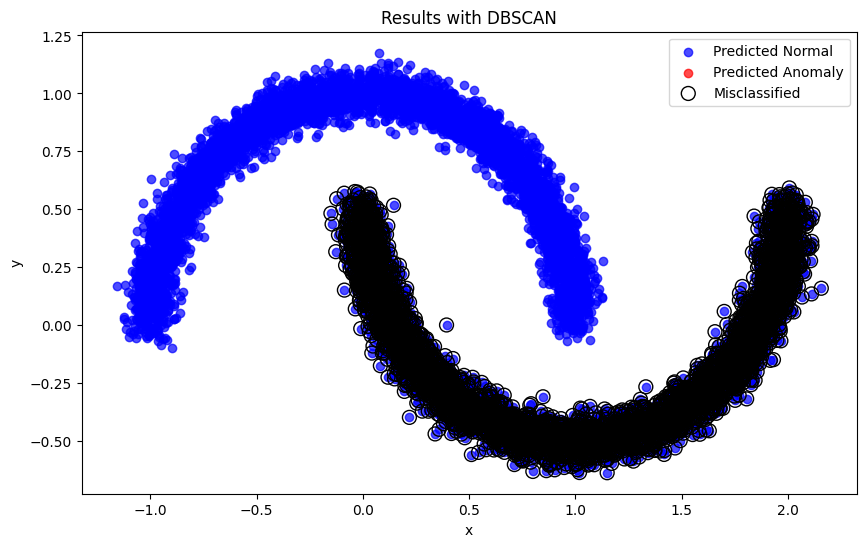

In [6]:
def plot_results(X_test, y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    
    # Plot the test data colored based on prediction
    plt.scatter(X_test[y_pred == 1, 0], X_test[y_pred == 1, 1], c='blue', label='Predicted Normal', alpha=0.7)
    plt.scatter(X_test[y_pred == -1, 0], X_test[y_pred == -1, 1], c='red', label='Predicted Anomaly', alpha=0.7)
    
    # Highlight misclassifications
    misclassified = np.where(y_true != y_pred)[0]
    plt.scatter(X_test[misclassified, 0], X_test[misclassified, 1], facecolors='none', edgecolors='black', s=100, label='Misclassified')
    
    plt.title(f'Results with {model_name}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

plot_results(X_test, test_ground_truth, y_pred_iso_binary, "Isolation Forest")
plot_results(X_test, test_ground_truth, y_pred_svm_binary, "One-Class SVM")
plot_results(X_test, test_ground_truth, y_pred_lof_binary, "Local Outlier Factor")
plot_results(X_test, test_ground_truth, y_pred_dbscan_binary, "DBSCAN")

Model: Ensemble (Majority Voting)
Accuracy: 0.9181
Precision: 1.0000
Recall: 0.8362
F1 Score: 0.9108
Confusion Matrix:
[[5000    0]
 [ 819 4181]]




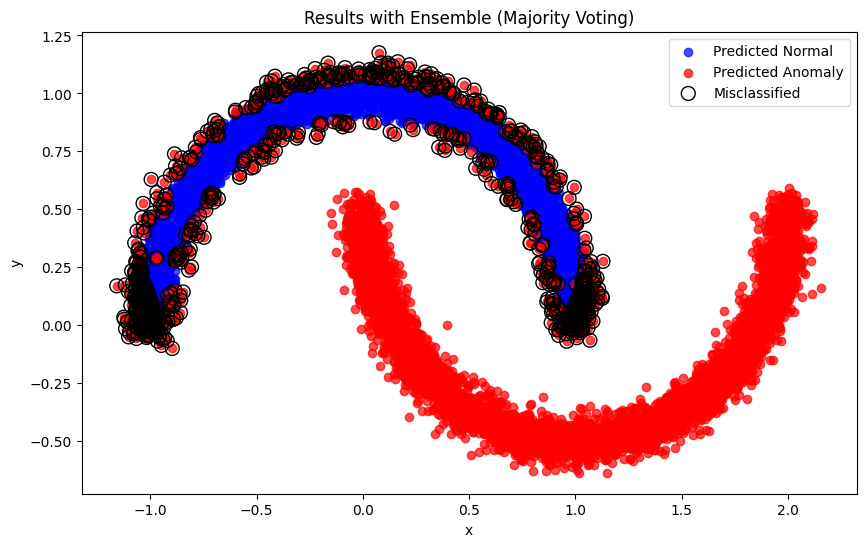

In [7]:
# Combine predictions from multiple models for a potential improvement
ensemble_preds = np.zeros(len(y_pred_iso_binary))

# Simple majority voting
for i in range(len(ensemble_preds)):
    votes = [y_pred_iso_binary[i], y_pred_svm_binary[i], 
             y_pred_lof_binary[i], y_pred_dbscan_binary[i]]
    ensemble_preds[i] = 1 if sum(votes) > 0 else -1

# Evaluate ensemble model
ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1 = evaluate_model(
    test_ground_truth, ensemble_preds, "Ensemble (Majority Voting)")

plot_results(X_test, test_ground_truth, ensemble_preds, "Ensemble (Majority Voting)")

# Conclusion and analysis
- Based on the model evaluations, We can determine which approach works best for this specific dataset. The results will show how accurate the model is at distinguishing normal data points from anomalies.
- Generally, for moon-shaped data distributions like we see in the visualization, Local Outlier Factor and Isolation Forest often perform well because they're less dependent on the assumption of normal distribution.

### The key metrics to focus on are:

- Accuracy: Overall correctness
- Precision: How many of the predicted anomalies are actually anomalies
- Recall: What proportion of actual anomalies were correctly identified
- F1-score: The harmonic mean of precision and recall

Based on the F1-score, We can identify which model or ensemble approach worked best for this specific anomaly detection task.